# Understanding School Performance on Pennsylvania Standardized Tests

## Extended Modeling - Part 2

The purpose of this notebook is to select one observation (i.e. one school) from our dataset and produce counterfactual explanations using our model to improve its performance standardized tests.  The models that we will work with are as follows:

- <b>ELA:</b> XGBoost with all features included
- <b>Math:</b> XGBoost with high correlation features removed

The school that we will select has 0 for ELA AND math target values, meaning that 0% of students are proficient or above in ELA and math.  Our objective will be to see if we can find adjustments in features that will bring our target values to at least 10 (meaning 10% of students are proficient or above for ELA and Math).  We are determining what it will take to bring our target value to this threshold.

In our previous notebook, we used the SHAP package to analyze the impact of our features on our target variable. Based on our observations from the summary plot, as well as our intuition of the domain space, we will produce counterfactuals by altering the following features one at a time:
- Economically Disadvantaged
- Percent Regular Attendance (All Student)
- Local - Personnel

When evaluating our counterfactual predictions, we remind ourselves that the <b>mean absolute error</b> on the test set for the ELA model is 6.40.  For the math model, the mean absolute error is 8.91.

### Contents:

- [1 - Import packages and load files](#section1)
- [2 - Identify observation](#section2)
- [3 - ELA Counterfactuals](#section3)
  - [3.1 - Economically disadvantaged](#section3.1)
  - [3.2 - Percent Regular Attendance (All Student)](#section3.2)
  - [3.3 - Local - Personnel](#section3.3)
  - [3.4 Bayesian Optimization for ELA Counterfactuals](#section3.4)
- [4 - Math Counterfactuals](#section4)
  - [4.1 - Economically disadvantaged](#section4.1)
  - [4.2 - Percent Regular Attendance (All Student)](#section4.2)
  - [4.3 - Local - Personnel](#section4.3)
  - [4.4 Bayesian Optimization for Math Counterfactuals](#section4.4)
- [5 - Recommendations](#section5)
- [6 - Future work](#section6)

<a id='section1'></a>
## 1. Import packages and load files

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import pickle

from bayes_opt import BayesianOptimization

In [2]:
# load datasets
X_train = pd.read_csv('../Data/X_train_scaled.csv', index_col = 0)
X_test = pd.read_csv('../Data/X_test_scaled.csv', index_col = 0)

X_train2 = pd.read_csv('../Data/X_train_scaled2.csv', index_col = 0)
X_test2 = pd.read_csv('../Data/X_test_scaled2.csv', index_col = 0)

X_train_orig = pd.read_csv('../Data/X_train.csv', index_col = 0).reset_index(drop=True)
X_test_orig = pd.read_csv('../Data/X_test.csv', index_col = 0)

ELA_train = pd.read_csv('../Data/y_train_ELA.csv', index_col = 0)
ELA_test = pd.read_csv('../Data/y_test_ELA.csv', index_col = 0)

math_train = pd.read_csv('../Data/y_train_math.csv', index_col = 0)
math_test = pd.read_csv('../Data/y_test_math.csv', index_col = 0)

In [3]:
# load highly correlated features list

with open('../Data/corr_features.pkl', 'rb') as f:
    corr_features = pickle.load(f)

In [4]:
# drop high correlation features from our original data
X_train2_orig = X_train_orig.drop(corr_features, axis = 1)
X_test2_orig = X_test_orig.drop(corr_features, axis = 1)

In [5]:
# load models
with open('../Models/ELA_model.pkl', 'rb') as f:
    ELA_model = pickle.load(f)
    
with open('../Models/math_model.pkl', 'rb') as f:
    math_model = pickle.load(f)

<a id='section2'></a>
## 2. Identify observation

We'll search our train and test target variables to see how many rows we have where the target variable is equal to 0. 

In [6]:
#count total number of rows in train set with ELA target = 0
sum(ELA_train['Percent Proficient in ELA']==0)

2

In [7]:
#count total number of rows in test set with ELA target = 0
sum(ELA_test['Percent Proficient in ELA']==0)

0

In [8]:
#count total number of rows in train set with math target = 0
sum(math_train['Percent Proficient in Math']==0)

3

In [9]:
#count total number of rows in train set with ELA target = 0
sum(math_test['Percent Proficient in Math']==0)

0

Our train set seems to have 2 instances with the ELA target equal to 0 and 3 instances where the Math target equals 0.

In [10]:
#find rows where the ELA target = 0
ELA_train[ELA_train['Percent Proficient in ELA']==0]

,Percent Proficient in ELA
94,0.0
1901,0.0


In [11]:
#find rows where the math target = 0
math_train[math_train['Percent Proficient in Math']==0]

,Percent Proficient in Math
94,0.0
1678,0.0
1901,0.0


We'll select the row that is indexed at 94 for our analysis.

In [12]:
index = 94

In [13]:
# observation row from train set (scaled)
X_train.iloc[index]

Title I (Binary)                             0.854268
School Enrollment                           -1.105340
Male (School)                                3.353083
Female (School)                             -3.353087
Percent Regular Attendance (All Student)    -6.273694
American Indian/Alaskan Native              -0.589087
Asian                                       -0.580679
Black/African American                       3.269251
Hispanic                                    -0.464803
Native Hawaiian or other Pacific Islander   -0.435799
White                                       -2.113144
2 or More Races                             -0.931511
English Learner                             -0.555150
Special Education                            0.776074
Percent of Gifted Students                  -0.891939
Economically Disadvantaged                   0.825337
Foster Care                                  5.401053
Homeless                                    -0.851883
Military Connected          

In [14]:
# observation row from the original train set (unscaled)
X_train_orig.iloc[index]

Title I (Binary)                                 1.00
School Enrollment                              115.00
Male (School)                                   63.48
Female (School)                                 36.52
Percent Regular Attendance (All Student)        12.60
American Indian/Alaskan Native                   0.00
Asian                                            0.00
Black/African American                          96.52
Hispanic                                         2.61
Native Hawaiian or other Pacific Islander        0.00
White                                            0.00
2 or More Races                                  0.87
English Learner                                  0.00
Special Education                               21.74
Percent of Gifted Students                       0.00
Economically Disadvantaged                      66.09
Foster Care                                      6.96
Homeless                                         0.00
Military Connected          

In [15]:
# original prediction
ELA_model.predict(X_train.iloc[index].to_numpy().transpose().reshape(1, -1))

array([3.4587817], dtype=float32)

We'll create the same standard scaler objects we used when we originally preprocessed our data.  This way we can scale our updated features prior to running it through our models.

In [16]:
# instantiate standard scaler
sc1 = StandardScaler()

# fit the scaler on the training set and transform it
X_train_sc = sc1.fit_transform(X_train_orig)

# instantiate standard scaler
sc2 = StandardScaler()

# fit the scaler on the training set and transform it
X_train2_sc = sc2.fit_transform(X_train2_orig)

<a id='section3'></a>
## 3. ELA Counterfactuals

<a id='section3.1'></a>
### 3.1 Economically Disadvantaged

We'll start producing counterfactuals by altering the 'Economically Disadvantaged' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [17]:
X_train_orig.iloc[index]['Economically Disadvantaged']

66.09

Our original value for 'Economically Disadvantaged' is 66.09.  Since we know from our SHAP analysis that lower values of this variable have a positive impact on our target variable, we'll generate a list of values that incrementally decrease from the actual value.  We'll then use that list to create a dataframe with all identical features except for 'Economically Disadvantaged'

In [18]:
# create list of alternative values for 'Economically Disadvantaged'
econ = np.arange(65, 49, -1)

In [19]:
#establish observation as a dataframe
econ_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
econ_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [20]:
# iterate through list of alternatives, update variable, and append this new row
for val in econ:
    econ_new_row['Economically Disadvantaged'] = val
    econ_df = econ_df.append(econ_new_row, ignore_index=True)

In [21]:
econ_df

,Title I (Binary),School Enrollment,Male (School),Female (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,...,Total Local Expenditure,State - Non-Personnel,State - Personnel,Total State Expenditure,Federal - Non-Personnel,Federal - Personnel,Total Federal Expenditure,Total Non-Personnel Expenditure,Total Personnel Expenditure,Total Expenditure
0,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
1,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
2,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
3,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
4,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
5,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
6,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
7,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
8,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
9,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59


In [22]:
# scale the data
econ_df_sc = sc1.transform(econ_df)

In [23]:
# make prediction
econ_pred_ELA = ELA_model.predict(econ_df_sc)

In [24]:
# generate a table comparing the altered value and the predicted target variable
econ_results_ELA = pd.DataFrame(zip(econ_df['Economically Disadvantaged'], list(econ_pred_ELA)), 
                            columns = ['% Economically Disadvantaged', '% Proficient in ELA (pred)']
                           )

econ_results_ELA

,% Economically Disadvantaged,% Proficient in ELA (pred)
0,66.09,3.458782
1,65.00,4.849619
2,64.00,5.216867
3,63.00,5.632399
4,62.00,5.780167
5,61.00,5.762795
6,60.00,8.528876
7,59.00,8.528876
8,58.00,8.573237
9,57.00,8.594182


We'll graph these results to visualize our counterfactuals.

In [25]:
[66.09] + list(np.arange(65,49, -1))

[66.09, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50]

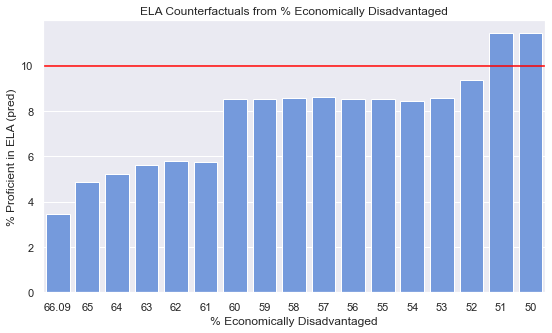

In [26]:
plt.figure(figsize=(9, 5))

order = [66.09] + list(np.arange(65,49, -1))

sns.barplot(x='% Economically Disadvantaged', 
            y='% Proficient in ELA (pred)', 
            data = econ_results_ELA,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('ELA Counterfactuals from % Economically Disadvantaged')
plt.show()

Our results show us that reductions in the percentage of families that are economically disadvantaged in a school is correlated with improved school performance in ELA.  In order to bring the target prediction above our threshold of 10%, it requires a reduction in 'Economically Disadvantaged' by 15, bringing it down to 51%.

<a id='section3.2'></a>
### 3.2  Percent Regular Attendance

Next we'll produce counterfactuals by altering the 'Percent Regular Attendance (All Student)' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [27]:
X_train_orig.iloc[index]['Percent Regular Attendance (All Student)']

12.6

Our original value for 'Percent Regular Attendance (All Student)' is 12.6, meaning that 12.6% of students have regular attendance records in this school.

Since we know from our SHAP analysis that higher values of this variable have a positive impact on our target variable, we'll generate a list of values that incrementally increase from the actual value.  We'll then use that list to create a dataframe with all identical features except for 'Percent Regular Attendance (All Student)'.

Based on our SHAP analysis, higher values of this variable may not have as strong of an effect as our previous analysis, so we'll try to look at a broader range of potential values.

In [28]:
# create list of alternative values for 'Percent Regular Attendance (All Student)'
att = np.arange(15, 85, 5)

In [29]:
#establish observation as a dataframe
att_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
att_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [30]:
# iterate through list of alternatives, update variable, and append this new row
for val in att:
    att_new_row['Percent Regular Attendance (All Student)'] = val
    att_df = att_df.append(att_new_row, ignore_index=True)

In [31]:
att_df

,Title I (Binary),School Enrollment,Male (School),Female (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,...,Total Local Expenditure,State - Non-Personnel,State - Personnel,Total State Expenditure,Federal - Non-Personnel,Federal - Personnel,Total Federal Expenditure,Total Non-Personnel Expenditure,Total Personnel Expenditure,Total Expenditure
0,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
1,1.0,115.0,63.48,36.52,15.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
2,1.0,115.0,63.48,36.52,20.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
3,1.0,115.0,63.48,36.52,25.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
4,1.0,115.0,63.48,36.52,30.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
5,1.0,115.0,63.48,36.52,35.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
6,1.0,115.0,63.48,36.52,40.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
7,1.0,115.0,63.48,36.52,45.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
8,1.0,115.0,63.48,36.52,50.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
9,1.0,115.0,63.48,36.52,55.0,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59


In [32]:
#scale the data
att_df_sc = sc1.transform(att_df)

In [33]:
# make prediction
att_pred_ELA = ELA_model.predict(att_df_sc)

In [34]:
# generate a table comparing the altered value and the predicted target variable
att_results_ELA = pd.DataFrame(zip(att_df['Percent Regular Attendance (All Student)'], list(att_pred_ELA)),
             columns = ['% Regular Attendance', '% Proficient in ELA (pred)']
            )


att_results_ELA

,% Regular Attendance,% Proficient in ELA (pred)
0,12.6,3.458782
1,15.0,3.458782
2,20.0,3.458782
3,25.0,3.458782
4,30.0,3.458782
5,35.0,3.458782
6,40.0,3.575382
7,45.0,3.729828
8,50.0,4.577289
9,55.0,5.119700


We'll visualize this with a bar plot.

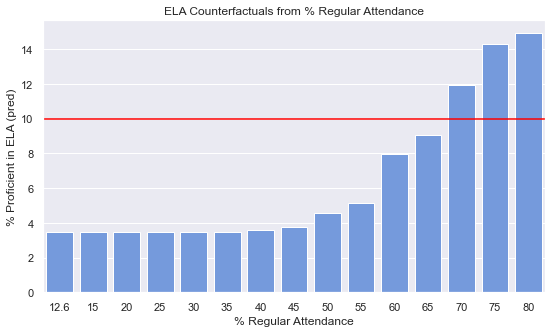

In [35]:
plt.figure(figsize=(9, 5))

order = [12.6] + list(np.arange(15,85,5))

sns.barplot(x='% Regular Attendance', 
            y='% Proficient in ELA (pred)', 
            data = att_results_ELA,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('ELA Counterfactuals from % Regular Attendance')
plt.show()

As expected, increases in Percent Regular Attendance do not a strong effect on our target variable.  In order to start seeing any noticeable differences at all in our target variable, our Percent Regular Attendance needed up jump from 12.6% to 55%.  

In order to reach our target threshold of 10%, the Percent Regular Attendance needed to increase by approximately 60, bringing it to a value of 70%.

<a id='section3.3'></a>
### 3.3 - Local - Personnel

Next we'll produce counterfactuals by altering the 'Local - Personnel' variable.  First, we'll look at the original value of this variable in our observation and then create a list of alternative values to replace it with and run it through our model.

In [36]:
X_train_orig.iloc[index]['Local - Personnel']

25885.22

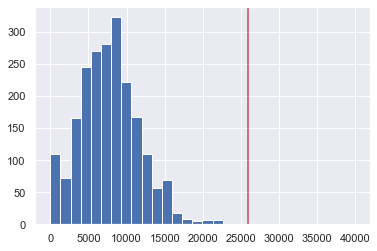

In [37]:
X_train_orig['Local - Personnel'].hist(bins=30)
plt.axvline(x=25885.22, color = 'r')
plt.show()

The original value of this variable for this school is \\$25,885.22.  Looking at the distribution of this variable, this value is already on the upper end of observed values. It's interesting that a school that spends this much money per student from local sources on personnel performs so poorly.

We'll create a list of alternative values that go up to \\$40,000 for this variable, with the understanding that it may not be likely that this school will be able to spend this much money from Local sources on Personnel.

In [38]:
# create list of alternative values for 'Local - Personnel'
loc = np.arange(26000, 41000, 1000)

In [39]:
#establish observation as a dataframe
loc_df = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
loc_new_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)

In [40]:
# iterate through list of alternatives, update variable, and append this new row
for val in loc:
    loc_new_row['Local - Personnel'] = val
    loc_df = loc_df.append(loc_new_row, ignore_index=True)

In [41]:
loc_df

,Title I (Binary),School Enrollment,Male (School),Female (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,...,Total Local Expenditure,State - Non-Personnel,State - Personnel,Total State Expenditure,Federal - Non-Personnel,Federal - Personnel,Total Federal Expenditure,Total Non-Personnel Expenditure,Total Personnel Expenditure,Total Expenditure
0,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
1,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
2,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
3,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
4,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
5,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
6,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
7,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
8,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59
9,1.0,115.0,63.48,36.52,12.6,0.0,0.0,96.52,2.61,0.0,...,28598.16,190.89,171.86,362.75,202.98,1716.7,1919.68,3106.81,27773.78,30880.59


In [42]:
#scale the data
loc_df_sc = sc1.transform(loc_df)

In [43]:
# make prediction
loc_pred_ELA = ELA_model.predict(loc_df_sc)

In [44]:
# generate a table comparing the altered value and the predicted target variable
loc_results_ELA = pd.DataFrame(zip(loc_df['Local - Personnel'], list(loc_pred_ELA)),
             columns = ['Local - Personnel', '% Proficient in ELA (pred)']
            )


loc_results_ELA

,Local - Personnel,% Proficient in ELA (pred)
0,25885.22,3.458782
1,26000.00,3.458782
2,27000.00,3.458782
3,28000.00,3.458782
4,29000.00,3.458782
5,30000.00,3.458782
6,31000.00,3.458782
7,32000.00,3.458782
8,33000.00,3.458782
9,34000.00,3.458782


We'll visualize this with a barplot.

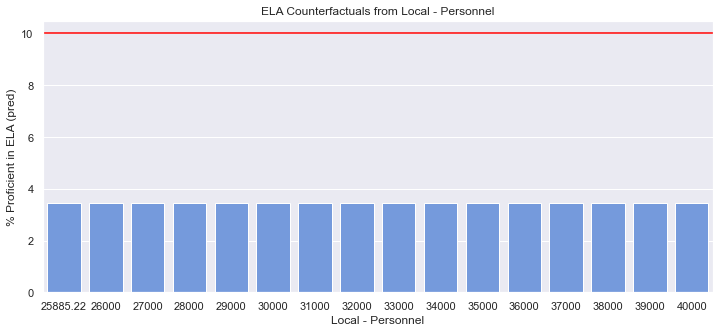

In [45]:
plt.figure(figsize=(12, 5))

order = [25885.22] + list(np.arange(26000,41000,1000))

sns.barplot(x='Local - Personnel', 
            y='% Proficient in ELA (pred)', 
            data = loc_results_ELA,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('ELA Counterfactuals from Local - Personnel')
plt.show()

As evident, these increases in 'Local - Personnel' do not cause our model's predictions for the target value to improve at all.  

<a id='section3.4'></a>
### 3.3 Bayesian Optimization for ELA Counterfactuals

We'll also apply Bayesian Optimization to see if different combinations of alternative features will produce counterfactual explanations.  We'll use the same three features that we adjusted independently above:
- 'Economically Disadvantaged'
- 'Percent Regular Attendance (All Student)'
- 'Local - Personnel'

We'll set our goal for our target prediction of ELA school performance to be 10, and define our function which will take the alternative values of the features above and return the difference between the predicted value from our ELA model and the goal.

In [46]:
# goal for our predicted target value

goal = 10

# define our function to be optimized

def ELA_eval(econ_dis, pct_att, loc_pers):
    """Function that takes alternative values of features and returns difference between model prediction and goal"""
    
    # identify original row of our observation
    orig_row = pd.DataFrame(X_train_orig.iloc[index]).transpose().reset_index(drop = True)
    
    #reassign feature values
    orig_row['Economically Disadvantaged'] = econ_dis
    orig_row['Percent Regular Attendance (All Student)'] = pct_att
    orig_row['Local - Personnel'] = loc_pers
    
    #scale data
    scaled_row = sc1.transform(orig_row)
    
    #make prediction
    prediction = ELA_model.predict(scaled_row)
    
    # calculate difference between model prediction and goal
    difference = prediction - goal
    
    return difference[-1]

When running our bayesian optimization, we'll select the bounds of our parameters within reason to see if combinations of <i>smaller</i> changes in feature values can also bring us to our intended target goal of 10.

For 'Economically Disadvantaged', we'll select values from 55 to 66.09 (original).

For 'Percent Regular Attendance', we'll select values from 12.6 (original) to 30.

For 'Local - Personnel', we'll select values from 25885.22 (original) to 30000.

In [47]:
# run bayesian optimization
ELA_BO = BayesianOptimization(f=ELA_eval, 
                              pbounds={'econ_dis':(55, 66.09), 
                                       'pct_att':(12.6, 30),
                                       'loc_pers':(25885.22, 30000)}, 
                              random_state=16)

ELA_BO.maximize(init_points=5, n_iter = 20)

|   iter    |  target   | econ_dis  | loc_pers  |  pct_att  |
-------------------------------------------------------------
|  1        | -1.427    |  57.48    |  2.804e+0 |  22.18    |
|  2        | -1.461    |  55.51    |  2.737e+0 |  16.48    |
|  3        | -4.22     |  62.64    |  2.656e+0 |  13.82    |
|  4        | -5.246    |  65.44    |  2.82e+04 |  13.96    |
|  5        | -4.368    |  63.01    |  2.654e+0 |  16.95    |
|  6        | -1.406    |  56.58    |  2.804e+0 |  21.23    |
|  7        | -1.48     |  55.0     |  2.75e+04 |  12.6     |
|  8        | -1.48     |  55.0     |  2.72e+04 |  30.0     |
|  9        | -6.541    |  66.09    |  2.703e+0 |  12.6     |
|  10       | -6.541    |  66.09    |  2.767e+0 |  30.0     |
|  11       | -5.15     |  65.1     |  2.999e+0 |  20.43    |
|  12       | -5.246    |  65.32    |  2.728e+0 |  14.32    |
|  13       | -1.461    |  56.08    |  2.743e+0 |  18.49    |
|  14       | -1.48     |  55.0     |  2.793e+0 |  12.6     |
|  15   

In [48]:
# get features for max value
ELA_BO.max

{'target': -1.405817985534668,
 'params': {'econ_dis': 56.5824499671258,
  'loc_pers': 28041.697160418986,
  'pct_att': 21.23032451209734}}

Based on the Bayesian Optimization we ran above, the best features within our solution space were able to get us -1.406 away from our target goal of 10. The feature changes are as follows:

- 'Economically Disadvantaged' reduced from 66.09 to 56.58
- 'Percent Regular Attendance' increased from 12.6 to 21.23
- 'Local - Personnel' increased from 25885.22 to 28041.70

<a id='section4'></a>
## 4. Math Counterfactuals

Since we already have our alternative values for our three features, we can use those lists again.

<a id='section4.1'></a>
### 4.1 Economically Disadvantaged

In [49]:
#establish observation as a dataframe
econ_df2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)
econ_new_row2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)

In [50]:
# iterate through list of alternatives, update variable, and append this new row
for val in econ:
    econ_new_row2['Economically Disadvantaged'] = val
    econ_df2 = econ_df2.append(econ_new_row2, ignore_index=True)

In [51]:
econ_df2

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,65.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,64.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,63.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,62.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,61.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,60.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,59.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,58.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,57.00,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7


In [52]:
# scale the data
econ_df2_sc = sc2.transform(econ_df2)

In [53]:
# make prediction
econ_pred_math = math_model.predict(econ_df2_sc)

In [54]:
# generate a table comparing the altered value and the predicted target variable
econ_results_math = pd.DataFrame(zip(econ_df2['Economically Disadvantaged'], list(econ_pred_math)), 
                            columns = ['% Economically Disadvantaged', '% Proficient in Math (pred)']
                           )

econ_results_math

,% Economically Disadvantaged,% Proficient in Math (pred)
0,66.09,1.871889
1,65.00,3.382949
2,64.00,4.005655
3,63.00,4.765068
4,62.00,5.005129
5,61.00,4.973159
6,60.00,9.356035
7,59.00,9.277983
8,58.00,9.163165
9,57.00,9.160842


We'll visualize this with a bar plot.

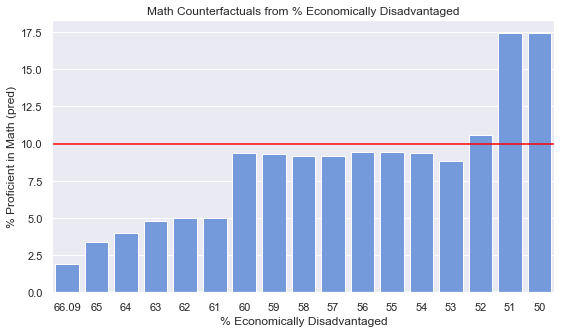

In [55]:
plt.figure(figsize=(9, 5))

order = [66.09] + list(np.arange(65,49, -1))

sns.barplot(x='% Economically Disadvantaged', 
            y='% Proficient in Math (pred)', 
            data = econ_results_math,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('Math Counterfactuals from % Economically Disadvantaged')
plt.show()

With our math model, we see similar counterfactual results when decreasing 'Economically Disadvantaged'.  To reach our target threshold of 10% for school math performance, the model requires that 'Economically Disadvantaged' decrease down to 52%. 

<a id='section4.2'></a>
### 4.2  Percent Regular Attendance

In [56]:
#establish observation as a dataframe
att_df2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)
att_new_row2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)

In [57]:
# iterate through list of alternatives, update variable, and append this new row
for val in att:
    att_new_row2['Percent Regular Attendance (All Student)'] = val
    att_df2 = att_df2.append(att_new_row2, ignore_index=True)

In [58]:
att_df2

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,15.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,20.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,25.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,30.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,35.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,40.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,45.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,50.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,55.0,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7


In [59]:
#scale the data
att_df2_sc = sc2.transform(att_df2)

In [60]:
# make prediction
att_pred_math = math_model.predict(att_df2_sc)

In [61]:
# generate a table comparing the altered value and the predicted target variable
att_results_math = pd.DataFrame(zip(att_df2['Percent Regular Attendance (All Student)'], list(att_pred_math)),
             columns = ['% Regular Attendance', '% Proficient in Math (pred)']
            )


att_results_math

,% Regular Attendance,% Proficient in Math (pred)
0,12.6,1.871889
1,15.0,1.871889
2,20.0,1.871889
3,25.0,1.871889
4,30.0,1.871889
5,35.0,1.905214
6,40.0,1.905214
7,45.0,1.905214
8,50.0,2.016361
9,55.0,2.027823


We'll visualize this with a barplot.

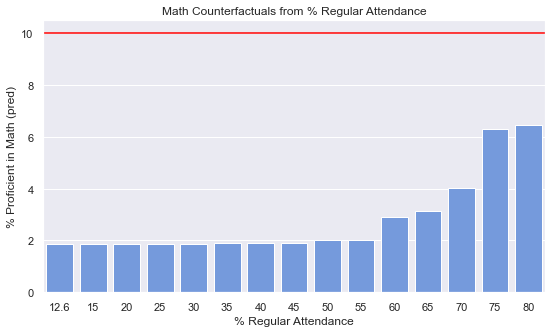

In [62]:
plt.figure(figsize=(9, 5))

order = [12.6] + list(np.arange(15,85,5))

sns.barplot(x='% Regular Attendance', 
            y='% Proficient in Math (pred)', 
            data = att_results_math,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('Math Counterfactuals from % Regular Attendance')
plt.show()

Similar to our ELA counterfactuals for 'Percent Regular Attendance', the effect of increasing this feature on school math performance is not significant.  In fact, increasing it from the original 12.6% to 80% only brings the target value up to 6.4%. 

<a id='section4.3'></a>
### 4.3 - Local - Personnel

In [63]:
#establish observation as a dataframe
loc_df2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)
loc_new_row2 = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)

In [64]:
# iterate through list of alternatives, update variable, and append this new row
for val in loc:
    loc_new_row2['Local - Personnel'] = val
    loc_df2 = loc_df2.append(loc_new_row2, ignore_index=True)

In [65]:
loc_df2

,Title I (Binary),School Enrollment,Male (School),Percent Regular Attendance (All Student),American Indian/Alaskan Native,Asian,Black/African American,Hispanic,Native Hawaiian or other Pacific Islander,2 or More Races,...,Economically Disadvantaged,Foster Care,Homeless,Military Connected,Local - Non-Personnel,Local - Personnel,State - Non-Personnel,State - Personnel,Federal - Non-Personnel,Federal - Personnel
0,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,25885.22,190.89,171.86,202.98,1716.7
1,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,26000.00,190.89,171.86,202.98,1716.7
2,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,27000.00,190.89,171.86,202.98,1716.7
3,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,28000.00,190.89,171.86,202.98,1716.7
4,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,29000.00,190.89,171.86,202.98,1716.7
5,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,30000.00,190.89,171.86,202.98,1716.7
6,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,31000.00,190.89,171.86,202.98,1716.7
7,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,32000.00,190.89,171.86,202.98,1716.7
8,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,33000.00,190.89,171.86,202.98,1716.7
9,1.0,115.0,63.48,12.6,0.0,0.0,96.52,2.61,0.0,0.87,...,66.09,6.96,0.0,0.0,2712.94,34000.00,190.89,171.86,202.98,1716.7


In [66]:
#scale the data
loc_df2_sc = sc2.transform(loc_df2)

In [67]:
# make prediction
loc_pred_math = math_model.predict(loc_df2_sc)

In [68]:
# generate a table comparing the altered value and the predicted target variable
loc_results_math = pd.DataFrame(zip(loc_df2['Local - Personnel'], list(loc_pred_math)),
             columns = ['Local - Personnel', '% Proficient in Math (pred)']
            )


loc_results_math

,Local - Personnel,% Proficient in Math (pred)
0,25885.22,1.871889
1,26000.00,1.871889
2,27000.00,1.871889
3,28000.00,1.871889
4,29000.00,1.871889
5,30000.00,1.871889
6,31000.00,1.871889
7,32000.00,1.871889
8,33000.00,1.871889
9,34000.00,1.871889


We'll visualize these results with a barplot.

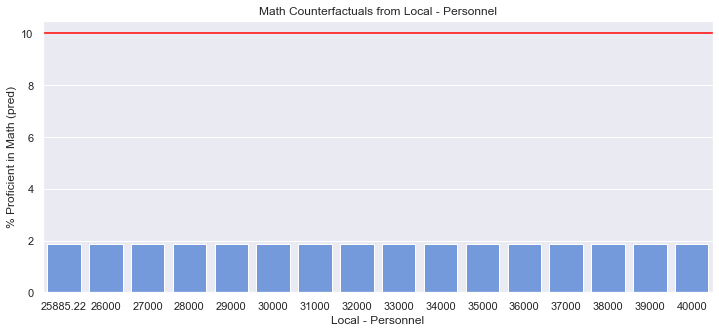

In [69]:
plt.figure(figsize=(12, 5))

order = [25885.22] + list(np.arange(26000,41000,1000))

sns.barplot(x='Local - Personnel', 
            y='% Proficient in Math (pred)', 
            data = loc_results_math,
            color = 'cornflowerblue',
            order = order
           )
plt.axhline(y=10, color = 'red')
plt.title('Math Counterfactuals from Local - Personnel')
plt.show()

As we've seen with our ELA counterfactuals for 'Local - Personnel', increases in this feature do not affect our target value.

<a id='section4.4'></a>
### 4.4 Bayesian Optimization for Math Counterfactuals

We'll apply the same Bayesian Optimization process for our math model to see if combinations of <i>smaller</i> changes in the features above can get us close to our target goal of 10.

In [70]:
# goal for our predicted target value

goal = 10

# define our function to be optimized

def math_eval(econ_dis, pct_att, loc_pers):
    """Function that takes alternative values of features and returns difference between model prediction and goal"""
    
    # identify original row of our observation
    orig_row = pd.DataFrame(X_train2_orig.iloc[index]).transpose().reset_index(drop = True)
    
    #reassign feature values
    orig_row['Economically Disadvantaged'] = econ_dis
    orig_row['Percent Regular Attendance (All Student)'] = pct_att
    orig_row['Local - Personnel'] = loc_pers
    
    #scale data
    scaled_row = sc2.transform(orig_row)
    
    #make prediction
    prediction = math_model.predict(scaled_row)
    
    # calculate difference between model prediction and goal
    difference = prediction - goal
    
    return difference[-1]

In [71]:
# run bayesian optimization
math_BO = BayesianOptimization(f=math_eval, 
                              pbounds={'econ_dis':(55, 66.09), 
                                       'pct_att':(12.6, 30),
                                       'loc_pers':(25885.22, 30000)}, 
                              random_state=16)

math_BO.maximize(init_points=5, n_iter = 20)

|   iter    |  target   | econ_dis  | loc_pers  |  pct_att  |
-------------------------------------------------------------
|  1        | -0.8849   |  57.48    |  2.804e+0 |  22.18    |
|  2        | -0.6066   |  55.51    |  2.737e+0 |  16.48    |
|  3        | -5.032    |  62.64    |  2.656e+0 |  13.82    |
|  4        | -6.728    |  65.44    |  2.82e+04 |  13.96    |
|  5        | -5.235    |  63.01    |  2.654e+0 |  16.95    |
|  6        | -0.5735   |  56.11    |  2.737e+0 |  13.68    |
|  7        | -0.5826   |  55.0     |  2.788e+0 |  27.76    |
|  8        | -0.5826   |  55.0     |  2.76e+04 |  30.0     |
|  9        | -8.128    |  66.09    |  2.705e+0 |  12.6     |
|  10       | -0.5735   |  56.13    |  3e+04    |  22.12    |
|  11       | -0.7408   |  58.43    |  2.975e+0 |  23.35    |
|  12       | -0.6592   |  60.16    |  2.945e+0 |  12.6     |
|  13       | -0.5826   |  55.0     |  2.916e+0 |  30.0     |
|  14       | -8.128    |  66.09    |  2.888e+0 |  12.6     |
|  15   

In [72]:
# get features for max value
math_BO.max

{'target': -0.5734939575195312,
 'params': {'econ_dis': 56.113986325921225,
  'loc_pers': 27372.17466781778,
  'pct_att': 13.682562046231387}}

Based on the Bayesian Optimization we ran above, the best features within our solution space were able to get us -0.57 away from our math target goal of 10. The feature changes are as follows:

- 'Economically Disadvantaged' reduced from 66.09 to 56.11
- 'Percent Regular Attendance' increased from 12.6 to 13.68
- 'Local - Personnel' increased from 25885.22 to 27372.17

<a id='section5'></a>
## 5. Recommendations

Among the three features we attempted to produce counterfactuals for, the only two that yielded improvements to the target variable were 'Economically Disadvantaged' and 'Percent Regular Attendance'. 

As we mentioned in our previous modeling notebook, it is not feasible nor ethical to simply reduce the number of students that come from economically disadvantaged families (or increase the number of students that come from wealthier families). With that said, while we are hesitant to suggest direct causation, an argument can be made towards increasing community engagement and support services for areas with high poverty rates as a means of improving local school performance.

Similarly for 'Percent Regular Attendance', we are hesitant to suggest direct causation here.  And while the improvement is not as significant as reducing 'Economically Disadvantaged', we can also make an argument for encouraging families to ensure that their children attend school as regularly as possible.  

Furthermore, it's possible that by investing in support services for areas with high poverty rates, the reduction of the percentage of economically disadvantaged will naturally improve attendance.  As families gain more stability, it may become easier for their children to consistently attend school.  In fact, in our previous notebook, we saw a similar pattern emerge in our dependence plots for math.  Lower values of 'Economically Disadvantaged' is correlated with higher values of 'Percent Regular Attendance''. 

As for our results from looking at alternative values for 'Local - Personnel', the lack of change in target value may point to the notion that simply pumping more money into underperforming schools will not improve performance.  As we mentioned in our previous notebook, the problems of underperforming schools may not be a result of issues <i>within</i> the school but rather a result of issues that face the local communities of these schools.  Therefore, the most effective solution involves connecting with the local communities of schools and improving the quality of life for struggling families as a means of reducing the percentage of families who are economically disadvantaged.

#### Recommendations:
- Research and invest in ideas to improve the quality of life for impoverished neighborhoods, such as:
    - Offering social services
    - Providing funding for adults to attend trade school or other educational opportunities
    - Providing micro loans to families with small businesses to expand their ventures

- Connect with the families of local communities of underperforming schools to emphasize the significance of consistent attendance.  Identify any common barriers that families may face in preventing their children from attending school regularly.

<a id='section6'></a>
## 6. Future work

There is certainly more work that can be explored to potentially improve the performance and interpretability of this model.

- During our exploratory data analysis, a few of our variables had some extreme outliers.  In this project, we checked the validity of those values from a separate source and decided to keep them.  It's possible that removing these outliers may help our models to better model the trend.
- After looking at the SHAP summary analysis, we can use the feature importance bar chart to select the most impactful features and only use them to train a new model, and compare the results of this new model with the previous XGboost models.
- It may also be interesting to consider looking at two datasets on PA school data from different school years, such as the 2016-2017 school year and then the 2018-2019 school year.  Perhaps a dataset can be constructed with features representing the <b>change</b> in feature values of the two datasets and the target variable representing the <b>change</b> in percent proficiency in ELA and/or math.  It would be interesting to create a model that will demonstrate which changes result in positive changes in school performance, as well as negative changes in school performance.